### 1. Installing required dependencies

#### 1.1. Using GPU for Training

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

2024-04-23 06:22:50.361360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 06:22:50.361451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 06:22:50.491894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### 1.2. Installing the Hugging Face Library

In [3]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

### 2. Loading Data

#### 2.1 TrainData

In [5]:
import pandas as pd

# Assuming you have the datasets in a local directory
local_true_csv_path = '/kaggle/input/news-data/News _dataset/True.csv'
local_fake_csv_path = '/kaggle/input/news-data/News _dataset/Fake.csv'

# Load the datasets into pandas dataframes.
df_true = pd.read_csv(local_true_csv_path, encoding='UTF-8')
df_fake = pd.read_csv(local_fake_csv_path, encoding='UTF-8')

# Creating target variable
df_true['target'] = 1
df_fake['target'] = 0

# Concatenating in one single dataframe using pandas.concat() instead of append
train_df = pd.concat([df_true, df_fake]).sample(frac=1).reset_index(drop=True)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)


Number of training sentences: 44,898



,title,text,subject,date,target
16844,"After FBI report, Clinton aides could find it ...",WASHINGTON (Reuters) - The FBI’s harsh critici...,politicsNews,"July 6, 2016",1
43021,House Republican Wants To Ban The Treasury Fr...,Long story short: a Republican member of the H...,News,"June 22, 2016",0
39376,"After Iowa, Trump’s Fragile Ego Totally Prepa...","According to Donald Trump, he didn t lose in...",News,"February 7, 2016",0
35139,U.S. executives tell Congress they want perman...,WASHINGTON (Reuters) - Wall Street and corpora...,politicsNews,"May 18, 2017",1
22067,AFTER 8 Years Of Silence From Obama On Cop Kil...,Here s just one of many discussions of assassi...,left-news,"Nov 11, 2016",0
39110,Delusional Obama On How Divided America Has Be...,It turns out we re not as divided as people ma...,politics,"Jan 12, 2016",0
30036,Obama administration denies Iran cash payment ...,WASHINGTON (Reuters) - The Obama administratio...,politicsNews,"August 3, 2016",1
11771,Race tightens in projected U.S. Electoral Coll...,NEW YORK (Reuters) - An election analysis cond...,politicsNews,"September 16, 2016",1
44340,Leading Democrat: Critics can't conclude Trump...,"WASHINGTON (Reuters) - Adam Schiff, the top De...",politicsNews,"August 20, 2017",1
2304,Factbox: Trump to meet this week with U.S. law...,(Reuters) - U.S. Republican President-elect Do...,politicsNews,"December 5, 2016",1


                                                    title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date  label  
count          44898               44898  44898  
unique             8                2397      2  
top     politicsNews  December 20, 2017    Fake  
freq           11272                 182  23481  


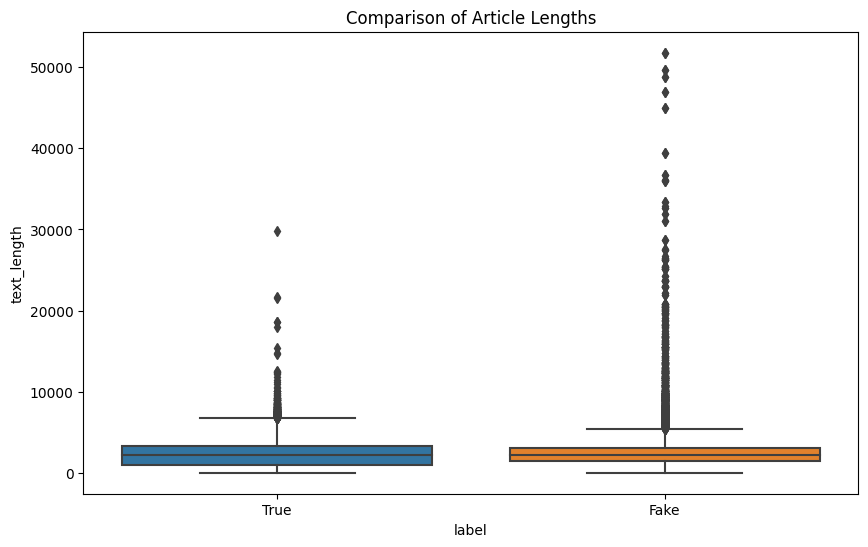

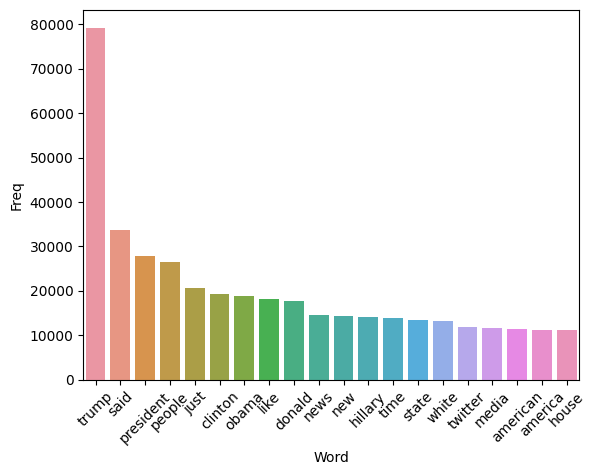

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
true_news = pd.read_csv('/kaggle/input/news-data/News _dataset/True.csv')
fake_news = pd.read_csv('/kaggle/input/news-data/News _dataset/Fake.csv')

# Add labels to the datasets
true_news['label'] = 'True'
fake_news['label'] = 'Fake'

# Combine the datasets
combined_news = pd.concat([true_news, fake_news])

# Basic exploration to understand the data
print(combined_news.describe())

# Analysis of article length as a potential pattern
combined_news['text_length'] = combined_news['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=combined_news)
plt.title('Comparison of Article Lengths')
plt.show()

# Word frequency analysis
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_n_words(text, n=20):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words = words_freq[:n]
    top_df = pd.DataFrame(top_words)
    top_df.columns=["Word", "Freq"]

    # Plot
    sns.barplot(x="Word", y="Freq", data=top_df)
    plt.xticks(rotation=45)
    plt.show()

# Plot top words in fake news
plot_top_n_words(fake_news['text'], n=20)


### 3. Pre-processing Text

In [7]:
# I have not written any code for text cleaning yet

In [8]:
# Get the lists of sentences and labels
sentences = train_df['title'].values
labels = train_df['target'].values
train_df['title'][10]

'Kuwait arrests five over video deemed offensive to crown prince'

### 4. Initializing the pre-trained models

Let's initialize the models with pre-trained weights. The list of pre-trained weights is available in [the official documentation](https://huggingface.co/transformers/pretrained_models.html). Downloading the weights may take a bit of time, but it only needs to be done once!

In [28]:
# loading pre-trained models
from transformers import (
    BertForSequenceClassification,
#     TFBertForSequenceClassification, 
                          BertTokenizer,
#                           TFRobertaForSequenceClassification,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                         AdamW)

# BERT
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                                num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                # You can increase this for multi-class tasks.   
                                                                output_attentions = False, # Whether the model returns attentions weights.
                                                                output_hidden_states = False # Whether the model returns all hidden-states.
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tell pytorch to run this model on the GPU.
bert_model.cuda()
                                                           

# RoBERTa
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                    # You can increase this for multi-class tasks.   
                                                                    output_attentions = False, # Whether the model returns attentions weights.
                                                                    output_hidden_states = False # Whether the model returns all hidden-states.
                                                                )
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

print(' Base models loaded')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Base models loaded


### 5. Tokenization

BERT and RoBERTa are both Transformer models that have the same architecture. As such, they accept only a certain kind of inputs: vectors of integers, each value representing a token. Each string of text must first be converted to a list of indices to be fed to the model. The tokenizer takes care of that for us.

BERT and RoBERTa may have the same architecture, but they differ in tokenization. BERT uses a sub-word tokenization, whereas RoBERTa uses the same tokenization than GPT-2: byte-level byte-pair-encoding. Let's see what this means:

Let's apply the tokenizer to one sentence just to see the output.

In [29]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the tweet split into tokens.
print('Tokenized BERT: ', bert_tokenizer.tokenize(sentences[0]))

# Print the tweet mapped to token ids.
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))

# Print the tweet split into tokens.
print('Tokenized RoBERT: ', roberta_tokenizer.tokenize(sentences[0]))

# Print the tweet mapped to token ids.
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))

 Original:  WHOA! COLLEGE SNOWFLAKE FREAKS OUT: Screams For Two Minutes Over A Trump Sign On Campus
Tokenized BERT:  ['whoa', '!', 'college', 'snow', '##fl', '##ake', 'freaks', 'out', ':', 'screams', 'for', 'two', 'minutes', 'over', 'a', 'trump', 'sign', 'on', 'campus']
Token IDs BERT:  [23281, 999, 2267, 4586, 10258, 13808, 29526, 2041, 1024, 11652, 2005, 2048, 2781, 2058, 1037, 8398, 3696, 2006, 3721]
Tokenized RoBERT:  ['WH', 'OA', '!', 'ĠCOL', 'LE', 'GE', 'ĠSN', 'OW', 'FL', 'A', 'KE', 'ĠFRE', 'AK', 'S', 'ĠOUT', ':', 'ĠScream', 's', 'ĠFor', 'ĠTwo', 'ĠMinutes', 'ĠOver', 'ĠA', 'ĠTrump', 'ĠSign', 'ĠOn', 'ĠCampus']
Token IDs RoBERTa:  [26369, 16024, 328, 14857, 3850, 8800, 13687, 4581, 7613, 250, 6961, 39924, 7140, 104, 14662, 35, 36250, 29, 286, 1596, 18925, 2306, 83, 140, 4313, 374, 14416]


We see a stark difference between how BERT and RoBERTa tokenize sentences

In [30]:
sequence = """Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️"""

bert_tokenized_sequence = bert_tokenizer.tokenize(sequence)
roberta_tokenized_sequence = roberta_tokenizer.tokenize(sequence)

print("""Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️""")
print("BERT:", bert_tokenized_sequence)
print("RoBERTa:", roberta_tokenized_sequence)

Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️
BERT: ['will', 'your', 'hometown', 'be', 'taking', 'in', 'obama', '’', 's', 'refugees', '?', 'here', '’', 's', 'the', 'list', 'of', 'cities', 'where', 'they', '’', 're', 'being', 'transplant', '##ed', '[UNK]']
RoBERTa: ['Will', 'ĠYour', 'ĠH', 'ometown', 'ĠBe', 'ĠTaking', 'ĠIn', 'ĠObama', 'âĢ', 'Ļ', 's', 'ĠRefugees', '?', 'ĠHere', 'âĢ', 'Ļ', 's', 'ĠThe', 'ĠList', 'ĠOf', 'ĠCities', 'ĠWhere', 'ĠThey', 'âĢ', 'Ļ', 're', 'ĠBeing', 'ĠTrans', 'pl', 'anted', 'ĠðŁ', 'ı', 'Ļ', 'ï¸ı']


**BERT Tokenizer**

Here, the BERT tokenizer splits the string into multiple substrings. If the substrings are in its vocabulary, they will stay as is: this is the case for `Cities`, `Taking` and `List`. However, if a resulting string is not in its vocabulary, it will be split again until every string is represented by its vocabulary. For example, `Transplanted` is split multiple times until every token is represented in the BERT vocabulary: it is split into three tokens.
The BERT tokenizer is lacking when it comes to complex characters spread over multiple bytes, as can be seen with emojis. In the sequence used, an emoji of a Cityscape was added. As the BERT tokenizer cannot interpret this emoji on a byte-level, it replaces it by the unknown token [UNK].

**RoBERTa Tokenizer**

On the other hand, the RoBERTa tokenizer has a slightly different approach. Here too, the string is split into multiple substrings, which are themselves split into multiple substrings until every substring can be represented by the vocabulary. However, the RoBERTa tokenizer has a **byte-level approach**. This tokenizer can represent every sequence as a combination of bytes, which makes it shine in the case of complex characters spread over multiple bytes, as with the Cityscape emoji. Instead of using the unknown token, this tokenizer can correctly encode the Cityscape emoji as the combination of multiple bytes. This tokenizer therefore does not require an unknown token, as it can handle every byte separately.

The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [31]:
max_len_bert = 0
max_len_roberta = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_bert = max(max_len_bert, len(input_ids_bert))
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))

    
print('Max sentence length BERT: ', max_len_bert)
print('Max sentence length RoBERTa: ', max_len_roberta)

Max sentence length BERT:  63
Max sentence length RoBERTa:  83


Just in case there are some longer test sentences, I'll set the maximum length to 120.

Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
6. The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks)

In [32]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs BERT:', bert_input_ids[1])
print('Token IDs RoBERTa:', roberta_input_ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  FATHER OF SON KILLED BY ILLEGAL Speaks Up On Democrats: “I ignore them like they ignore me” [Video]
Token IDs BERT: tensor([ 101, 2269, 1997, 2365, 2730, 2011, 6206, 8847, 2039, 2006, 8037, 1024,
        1523, 1045, 8568, 2068, 2066, 2027, 8568, 2033, 1524, 1031, 2678, 1033,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
Token IDs RoBERTa: tensor([    0,   597, 31711,  3243,   208,  2191, 412

/tmp/ipykernel_34/3829288429.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


### 6. Training & Validation Split

In [33]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)
roberta_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

In [34]:
# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
# check
trial_dataset =  index_remover(bert_dataset)
trial_dataset[0]
# yes we were able to remove the sentence id from the data without disturbing the data format

(tensor([  101, 23281,   999,  2267,  4586, 10258, 13808, 29526,  2041,  1024,
         11652,  2005,  2048,  2781,  2058,  1037,  8398,  3696,  2006,  3721,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])
roberta_train_dataset, roberta_val_dataset = random_split(roberta_dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
  sentence_ids_list_valid.append(a.tolist())

# removing sentence ids from tensor dataset so that it can be used for training 
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in bert_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real disater tweets'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in bert_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real disater tweets'.format(sum(label_temp_list)))

40,408 training samples
19,287 training samples with real disater tweets
4,490 validation samples
2,130 validation samples with real disater tweets


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Browsing all of the model's parameters by name here.

In the below cell, we have names and dimensions of the weights for:

The embedding layer.
The first of the twelve transformers.
The output layer

In [37]:
# Get all of the roberta_model's parameters as a list of tuples.
params = list(roberta_model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

### 7. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values :

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
We chose:

Batch size: 32 (set when creating our DataLoaders)
Learning rate: 2e-5
Epochs: 4 (we'll see that this is probably too many...)
The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"

In [38]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [39]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2,I have already seen that the model starts overfitting beyound 2 epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 8. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase.

**Training:**

1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Clear out the gradients calculated in the previous pass.
4. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
5. Forward pass (feed input data through the network)
6. Backward pass (backpropagation)
7. Tell the network to update parameters with optimizer.step()
8. Track variables for monitoring progress

**Evaluation:**

1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Forward pass (feed input data through the network)
4. Compute loss on our validation data and track variables for monitoring progress
5. Define a helper function for calculating accuracy.

In [40]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [41]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

#### 8.1 BERT

In [23]:
import numpy as np
import random
import time
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# Assuming the definition of `bert_model`, `bert_optimizer`, and `bert_scheduler` are done elsewhere
# Make sure to import necessary libraries and define or import your model, optimizer, scheduler, and dataloaders before this script

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Assuming `device` is defined (e.g., 'cuda' or 'cpu')
bert_model.to(device)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
bert_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 4  # Assuming `epochs` is defined

# Function to format time elapsed into hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    bert_model.train()

    for step, batch in enumerate(bert_train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        bert_model.zero_grad()        

        outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        bert_optimizer.step()
        bert_scheduler.step()

    avg_train_loss = total_train_loss / len(bert_train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("Running Validation...")

    t0 = time.time()

    bert_model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in bert_validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,263.    Elapsed: 0:00:15.
  Batch    80  of  1,263.    Elapsed: 0:00:29.
  Batch   120  of  1,263.    Elapsed: 0:00:43.
  Batch   160  of  1,263.    Elapsed: 0:00:56.
  Batch   200  of  1,263.    Elapsed: 0:01:10.
  Batch   240  of  1,263.    Elapsed: 0:01:24.
  Batch   280  of  1,263.    Elapsed: 0:01:38.
  Batch   320  of  1,263.    Elapsed: 0:01:52.
  Batch   360  of  1,263.    Elapsed: 0:02:06.
  Batch   400  of  1,263.    Elapsed: 0:02:20.
  Batch   440  of  1,263.    Elapsed: 0:02:34.
  Batch   480  of  1,263.    Elapsed: 0:02:48.
  Batch   520  of  1,263.    Elapsed: 0:03:01.
  Batch   560  of  1,263.    Elapsed: 0:03:15.
  Batch   600  of  1,263.    Elapsed: 0:03:29.
  Batch   640  of  1,263.    Elapsed: 0:03:43.
  Batch   680  of  1,263.    Elapsed: 0:03:57.
  Batch   720  of  1,263.    Elapsed: 0:04:11.
  Batch   760  of  1,263.    Elapsed: 0:04:25.
  Batch   800  of  1,263.    Elapsed: 0:04:39.
  Batch   840  of

In [24]:
# Save the trained model, the optimizer, and the scheduler. You can also include the epoch number if you want.
model_save_path = "bert.bin"

torch.save({
    'model_state_dict': bert_model.state_dict(),
    'optimizer_state_dict': bert_optimizer.state_dict(),
    'scheduler_state_dict': bert_scheduler.state_dict(),
    'training_stats': bert_training_stats,
    # Add any other things you need
}, model_save_path)


In [25]:
# Load the model and optimizer state dict
checkpoint = torch.load(model_save_path)

# Load model state
bert_model.load_state_dict(checkpoint['model_state_dict'])

# If you're continuing training, you'll also want to load the optimizer and scheduler states
bert_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
bert_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Don't forget to move the model to the right device after loading
bert_model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:
print(device)

cuda


#### 8.2 RoBERTa

In [42]:
# Assuming imports and setup for RoBERTa has been done correctly, including defining the model, data loaders, etc.

import torch
import numpy as np
import random
import time
from transformers import get_linear_schedule_with_warmup, AdamW

# Assuming `device` is defined, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Set seed for reproducibility
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training loop setup
epochs = 4
total_t0 = time.time()
roberta_training_stats = []

for epoch_i in range(0, epochs):
    # Training phase
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    roberta_model.train()

    for step, batch in enumerate(roberta_train_dataloader):
        # Progress update
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        roberta_model.zero_grad()

        # Perform a forward pass. This will return a tuple in Transformers v3.x and earlier.
        outputs = roberta_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()
        roberta_scheduler.step()

    avg_train_loss = total_train_loss / len(roberta_train_dataloader)
    training_time = format_time(time.time() - t0)

    # Validation phase
    print("\nRunning Validation...")
    t0 = time.time()

    roberta_model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in roberta_validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = roberta_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(roberta_validation_dataloader)
    validation_time = format_time(time.time() - t0)

    roberta_training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,263.    Elapsed: 0:00:14.
  Batch    80  of  1,263.    Elapsed: 0:00:28.
  Batch   120  of  1,263.    Elapsed: 0:00:42.
  Batch   160  of  1,263.    Elapsed: 0:00:56.
  Batch   200  of  1,263.    Elapsed: 0:01:10.
  Batch   240  of  1,263.    Elapsed: 0:01:24.
  Batch   280  of  1,263.    Elapsed: 0:01:38.
  Batch   320  of  1,263.    Elapsed: 0:01:52.
  Batch   360  of  1,263.    Elapsed: 0:02:06.
  Batch   400  of  1,263.    Elapsed: 0:02:20.
  Batch   440  of  1,263.    Elapsed: 0:02:34.
  Batch   480  of  1,263.    Elapsed: 0:02:48.
  Batch   520  of  1,263.    Elapsed: 0:03:02.
  Batch   560  of  1,263.    Elapsed: 0:03:16.
  Batch   600  of  1,263.    Elapsed: 0:03:30.
  Batch   640  of  1,263.    Elapsed: 0:03:44.
  Batch   680  of  1,263.    Elapsed: 0:03:59.
  Batch   720  of  1,263.    Elapsed: 0:04:13.
  Batch   760  of  1,263.    Elapsed: 0:04:27.
  Batch   800  of  1,263.    Elapsed: 0:04:41.
  Batch   840  of

In [43]:
# Save the trained model, the optimizer, and the scheduler. You can also include the epoch number if you want.
model_save_path = "roberta_model.bin"

torch.save({
    'model_state_dict': bert_model.state_dict(),
    'optimizer_state_dict': bert_optimizer.state_dict(),
    'scheduler_state_dict': bert_scheduler.state_dict(),
    'training_stats': bert_training_stats,
    # Add any other things you need
}, model_save_path)


In [44]:
# Load the model and optimizer state dict
checkpoint = torch.load(model_save_path)

# Load model state
bert_model.load_state_dict(checkpoint['model_state_dict'])

# If you're continuing training, you'll also want to load the optimizer and scheduler states
bert_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
bert_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Don't forget to move the model to the right device after loading
bert_model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### 9. Evaluation 

In [45]:
import pandas as pd

# Correctly set display floats with two decimal places.
pd.set_option('display.precision', 2)

# Assuming roberta_training_stats is defined and is a list of dictionaries representing training stats
# Example:
# roberta_training_stats = [{'epoch': 1, 'Training Loss': 0.5, 'Validation Loss': 0.4},
#                           {'epoch': 2, 'Training Loss': 0.3, 'Validation Loss': 0.2}]

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=roberta_training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
print(df_stats)


       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           1.42e-02         0.04            1.0       0:07:23         0:00:15
2           2.39e-03         0.04            1.0       0:07:23         0:00:15
3           1.03e-03         0.04            1.0       0:07:23         0:00:15
4           1.12e-03         0.04            1.0       0:07:23         0:00:15


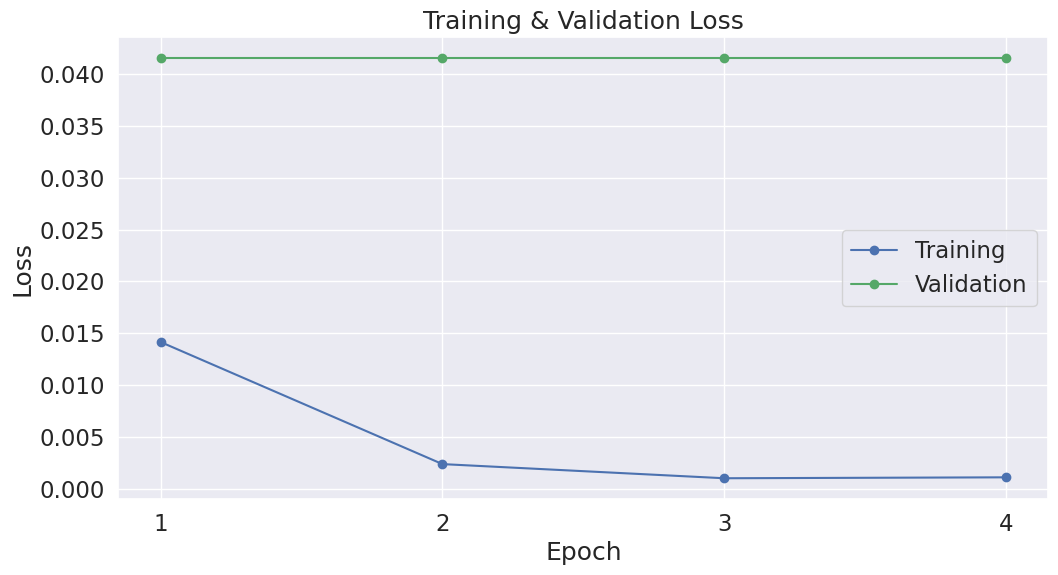

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### 10. Detalied Evaluation on Test data

In this scenario I shall pickup the validation dataset which was eariler created and shall use it for prediction. The features have already been created on the data so I would just use them for evaluation of our model as well

In [47]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df  = train_df.iloc[sentence_ids_list_valid,]

In [48]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.title.values
labels = df.target.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 75,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,490



/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [49]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 4,490 test sentences...
    DONE.


In [50]:
print('Positive samples: %d of %d (%.2f%%)' % (df.target.sum(), len(df.target), (df.target.sum() / len(df.target) * 100.0)))

Positive samples: 2130 of 4490 (47.44%)


In [51]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

Each batch has 32 sentences in it, except the last batch.

/tmp/ipykernel_34/2646804597.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


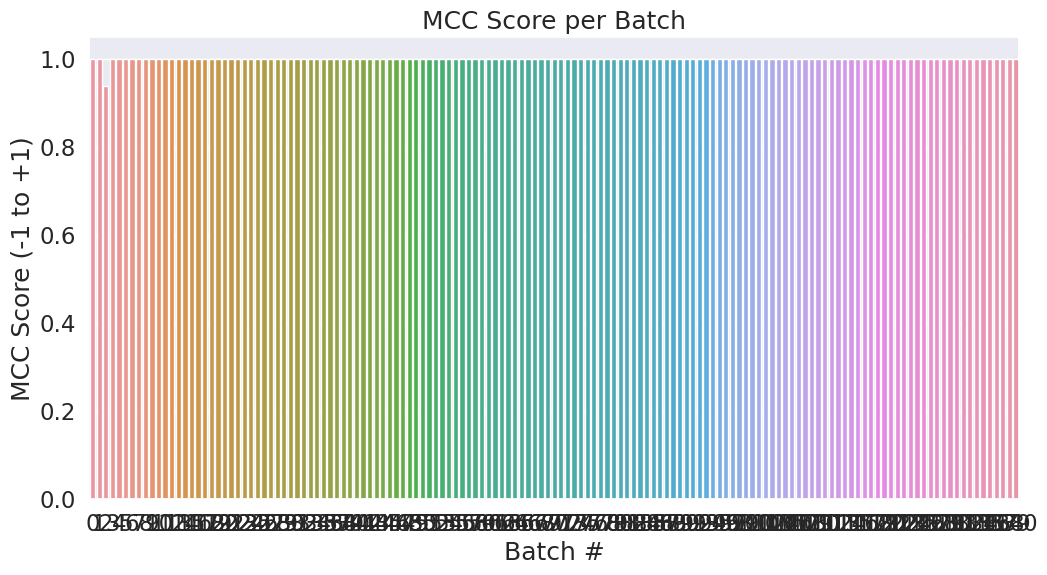

In [52]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [53]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# adding to the main datframe
df['target'] = flat_predictions

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
get_eval_report(flat_true_labels, flat_predictions)
# print('Total MCC: %.3f' % mcc)

/tmp/ipykernel_34/3910973808.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = flat_predictions


{'mcc': 0.9995535037055878, 'tp': 2130, 'tn': 2359, 'fp': 1, 'fn': 0}

/tmp/ipykernel_34/3394814540.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = flat_predictions


Evaluation Report:
{'mcc': 0.9995535037055878, 'tp': 2130, 'tn': 2359, 'fp': 1, 'fn': 0}


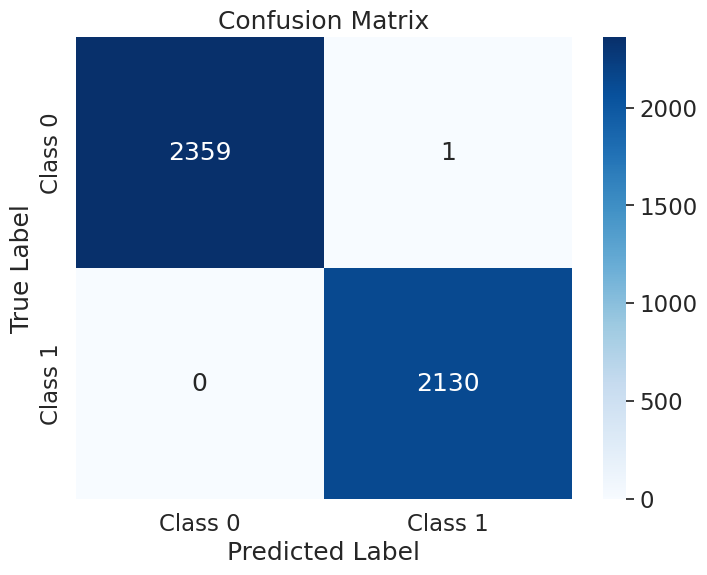

In [54]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# adding to the main dataframe
df['target'] = flat_predictions

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC and other evaluation metrics
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

evaluation_report = get_eval_report(flat_true_labels, flat_predictions)
print("Evaluation Report:")
print(evaluation_report)

# Draw confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

class_names = ['Class 0', 'Class 1']  # Replace with your actual class names
cm = confusion_matrix(flat_true_labels, flat_predictions)
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
